In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import threading
import obspy
from obspy.clients.seedlink.easyseedlink import create_client, EasySeedLinkClient

## realtime station information
http://ds.iris.edu/gmap/#network=_REALTIME&starttime=2021-03-01&datacenter=IRISDMC&networktype=permanent&planet=earth

http://ds.iris.edu/gmap/#network=_REALTIME&channel=HH*&starttime=2021-03-01&datacenter=IRISDMC&networktype=permanent&planet=earth

In [2]:
stations = pd.read_csv("realtime-stations.txt", sep="|",  header=None, skiprows=3, names=["network", "station", "latitude", "longitude", "elevation(m)", "location", "starttime", "endtime"])
stations = stations[stations["network"] == "UW"]

(-124.93312499999999, -116.860775, 42.419448000000003, 49.159191999999997)

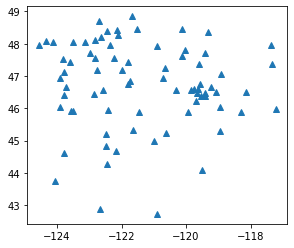

In [3]:
plt.figure()
plt.plot(stations["longitude"], stations["latitude"], '^')
plt.axis("scaled")

9


(-124.61931, -123.45088999999999, 46.584474550000003, 48.157836449999998)

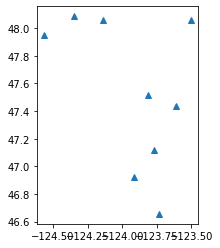

In [8]:
stations = stations[(46.5 < stations["latitude"]) & (stations["latitude"] < 49)]
stations = stations[(-125 < stations["longitude"]) & (stations["longitude"] < -123.5)]
stations["station_id"] = stations["network"] + "." + stations["station"]
stations = stations.reset_index()
print(len(stations))
plt.figure()
plt.plot(stations["longitude"], stations["latitude"], '^')
plt.axis("scaled")

In [10]:
stations

,level_0,index,network,station,latitude,longitude,elevation(m),location,starttime,endtime,station_id
0,0,1479,UW,CORE,46.925700,-123.913600,46.0,"Aberdeen, WA, USA",2015-08-04T00:00:00,2599-12-31T23:59:59,UW.CORE
1,1,1486,UW,FORK,47.947500,-124.566200,44.9,"Forks, WA, USA",2009-11-18T00:00:00,2599-12-31T23:59:59,UW.FORK
2,2,1502,UW,LRIV,48.057500,-123.504000,293.8,"Port Angeles, WA, USA",2009-08-27T00:00:00,2599-12-31T23:59:59,UW.LRIV
3,3,1510,UW,OLQN,47.513250,-123.812520,86.3,Olympic Peninsula Lake Quinault WA,2019-06-05T00:00:00,2599-12-31T23:59:59,UW.OLQN
4,4,1514,UW,OTR,48.086320,-124.345180,541.6,"Olympic Penninsula - Tyee Ridge, WA, USA",1984-06-01T00:00:00,2599-12-31T23:59:59,UW.OTR
5,7,1527,UW,SLDQ,48.062240,-124.140920,297.0,"Solduck, Olympic Peninsula, WA, USA",2019-06-14T00:00:00,2599-12-31T23:59:59,UW.SLDQ
6,8,1541,UW,WHGC,46.655991,-123.729866,5.4,Willapa Harbor Golf Course,2019-02-03T00:00:00,2599-12-31T23:59:59,UW.WHGC
7,9,1542,UW,WISH,47.116980,-123.771180,45.0,"Wishka, WA, USA",2004-04-20T00:00:00,2599-12-31T23:59:59,UW.WISH
8,10,1544,UW,WYNO,47.433920,-123.612960,935.4,"Wynoochee Dam Area, Olympic National Forest, W...",2019-12-31T00:00:00,2599-12-31T23:59:59,UW.WYNO


In [12]:
class Client(EasySeedLinkClient):
    def on_data(self, trace):
        print('Received trace:', trace.id)
        print(trace)
            
client = Client('rtserve.iris.washington.edu:18000')
for index, row in stations.iterrows():
    client.select_stream(row["network"], row["station"], "HH?")
client.run()

Received trace: UW.WISH..HHE
UW.WISH..HHE | 2021-03-30T17:05:05.510000Z - 2021-03-30T17:05:07.560000Z | 100.0 Hz, 206 samples
Received trace: UW.WISH..HHE
UW.WISH..HHE | 2021-03-30T17:05:07.570000Z - 2021-03-30T17:05:10.110000Z | 100.0 Hz, 255 samples
Received trace: UW.WISH..HHE
UW.WISH..HHE | 2021-03-30T17:05:10.119999Z - 2021-03-30T17:05:13.129999Z | 100.0 Hz, 302 samples
Received trace: UW.WISH..HHN
UW.WISH..HHN | 2021-03-30T17:05:05.570000Z - 2021-03-30T17:05:07.620000Z | 100.0 Hz, 206 samples
Received trace: UW.WISH..HHN
UW.WISH..HHN | 2021-03-30T17:05:07.630000Z - 2021-03-30T17:05:10.530000Z | 100.0 Hz, 291 samples
Received trace: UW.CORE..HHE
UW.CORE..HHE | 2021-03-30T17:05:02.860000Z - 2021-03-30T17:05:06.910000Z | 100.0 Hz, 406 samples
Received trace: UW.CORE..HHE
UW.CORE..HHE | 2021-03-30T17:05:06.920000Z - 2021-03-30T17:05:11.080000Z | 100.0 Hz, 417 samples
Received trace: UW.CORE..HHE
UW.CORE..HHE | 2021-03-30T17:05:11.090000Z - 2021-03-30T17:05:14.680000Z | 100.0 Hz, 360 

KeyboardInterrupt: 